In [1]:
# [CLEAR VARIABLES]
%reset

In [2]:
# [IMPORT PACKAGES]
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import IPython as ip
from IPython import display as display
import seaborn as sns
import sklearn as sk
import random
import time

# [IMPORT DATASET]
ks = pd.read_csv('ks2018.csv')
print("-"*100,'\nData set: {} samples'.format(ks.shape[0]))
print("-"*100)

# [NULL DATA]
print('Null values:')
print(ks.isnull().sum())
print("-"*100)
print('Percentage missing for "name" %.4f%%' %((ks['name'].isnull().sum()/ks.shape[0])*100))
print('Percentage missing for "usd pledged" %.4f%%' %((ks['usd pledged'].isnull().sum()/ks.shape[0])*100))
print("-"*100)

# [POSSIBLE OUTCOMES]
print('Outcomes: ', list(ks.state.unique()))
print("-"*100)

# [LIVE PROJECTS]
live = ks.apply(lambda x: True if x['state'] == 'live' else False , axis=1)
print('The amount of live projects is: ', len(live[live == True].index))
print('This is %.2f%% of the total projects' %((len(live[live == True].index)/ks.shape[0])*100))
print("-"*100)

pd.set_option('display.max_columns', None)

---------------------------------------------------------------------------------------------------- 
Data set: 378661 samples
----------------------------------------------------------------------------------------------------
Null values:
ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64
----------------------------------------------------------------------------------------------------
Percentage missing for "name" 0.0011%
Percentage missing for "usd pledged" 1.0027%
----------------------------------------------------------------------------------------------------
Outcomes:  ['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']
----

In [3]:
# DATA [CORRECTION, COMPLETION, CONVERSION, DELETION]

# remove live projects (0.74% of all data)
ks = ks.query('state != "live"')

# set state to 1 if successful, 0 otherwise, 1 is used for the 'rare class', there are more failed projects thant successful projects
ks['outcome'] = (ks['state'] == 'successful').astype(float)

# remove projects with null names (0.0011% of all data)
ks.drop(ks[ks.name.isnull()].index, axis=0, inplace=True, errors='ignore')

# remove outliers: goal over 30 000 000 (unrealistic, jokes)
ks.drop(ks[ks.goal > 30000000].index, inplace=True, errors='ignore')

# convert launched and deadline columns to datetime objects
ks['launched'] = pd.to_datetime(ks['launched'])
ks['deadline'] = pd.to_datetime(ks['deadline'])

# give unix-time anomalies a new launch date, 30 days before deadline (median, in order to not mess with data)
ks.loc[pd.DatetimeIndex(ks['launched']).year < 2000, 'launched'] = ks['deadline'] - pd.to_timedelta(30, unit='d')


In [4]:
# FEATURE [CREATION, ENGINEERING]
from sklearn.preprocessing import LabelEncoder

# log transformation on goal column
ks['goal'] = np.log(ks.goal)

# create titlelength feature (length of the project name)
ks['tlength'] = ks['name'].str.len()

# create duration feature (campaign duration in days, rounded up)
ks['duration'] = ((ks['deadline'] - ks['launched']) / np.timedelta64(1, 'D')).round(0).astype(int)

# remove outliers: duration over 85
ks.drop(ks[ks.duration > 85].index, inplace=True, errors='ignore')

# create category_country feature (combination of category + country)
ks['category_country'] = ks['category'] + "_" + ks['country']

# create launch features (year, month [1,12], day of week [0,6], hour and is_weekend)
ks['lyear'] = pd.DatetimeIndex(ks['launched']).year
ks['lmonth'] = pd.DatetimeIndex(ks['launched']).month
ks['lday'] = pd.DatetimeIndex(ks['launched']).dayofweek
ks['lhour'] = pd.DatetimeIndex(ks['launched']).hour
ks["l_is_weekend"] = ks["lday"].apply(lambda x: 1 if x > 4 else 0)

# create deadline features (year, month [1,12] and day of week [0,6])
ks['dyear'] = pd.DatetimeIndex(ks['deadline']).year
ks['dmonth'] = pd.DatetimeIndex(ks['deadline']).month
ks['dday'] = pd.DatetimeIndex(ks['deadline']).dayofweek 

# create project_competition feature (number of projects launched in past week)
launches = pd.Series(ks.index, index=ks.launched, name="project_competition").sort_index()
project_competition = launches.rolling('7d').count() - 1 
project_competition.index = launches.values
ks['project_competition'] = project_competition.reindex(ks.index)

# create category_competition feature (time since last project in same category was launched)
def time_since_last_project(series): return series.diff().dt.total_seconds() / 3600.
df = ks[['category', 'launched']].sort_values('launched')
timedeltas = df.groupby('category').transform(time_since_last_project)
ks['category_competition'] = timedeltas.fillna(timedeltas.median()).reindex(ks.index)

# create success ratio feature (kickstarter success ratio during previous month)
df = ks[['outcome', 'deadline']].sort_values('deadline')
df['outcome'] = df['outcome'].astype(float)
df['sum_outcomes'] = df['outcome'].rolling(window=30).sum() - df['outcome'] 
df['count_outcomes'] = df['outcome'].rolling(window=30).count()
df['success_ratio'] = df['sum_outcomes']/df['count_outcomes']
ks['success_ratio'] = df['success_ratio'].fillna(df['success_ratio'].median()).reindex(ks.index)

# create money spent feature (how much money was already spent last month)
df = ks[['pledged', 'deadline']].sort_values('deadline')
df['sum_pledged'] = df['pledged'].rolling(window=30).sum() - df['pledged'] 
ks['money_spent'] = df['sum_pledged'].fillna(df['sum_pledged'].median()).reindex(ks.index)


In [5]:
# [CATEGORICAL ENCODING] [ONE HOT, LABEL, COUNT, TARGET, CATBOOST]

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

# categorical features to be encoded
features = ['main_category', 'currency', 'country', 'category_country', 'category']

# encoders
l_encoder = LabelEncoder() # encode target labels with value between 0 and n_classes-1.
c_encoder = ce.CountEncoder() # replaces each categorical value with the number of times it appears in the dataset
t_encoder = ce.TargetEncoder(cols=features) # replaces a categorical value with the average value of the target for that value of the feature
cb_encoder = ce.CatBoostEncoder(cols=features) # for each row, the target probability is calculated only from the rows before it

# encoded features
l_encoded = ks[features].apply(l_encoder.fit_transform)
c_encoded = c_encoder.fit_transform(ks[features])
t_encoded = t_encoder.fit_transform(ks[features], ks['outcome'])
cb_encoded = cb_encoder.fit_transform(ks[features], ks['outcome'])

# drop categorical data since it is now encoded
ks.drop('currency', axis=1, inplace=True)
ks.drop('country', axis=1, inplace=True)
ks.drop('main_category', axis=1, inplace=True)
ks.drop('category', axis=1, inplace=True)
ks.drop('category_country', axis=1, inplace=True)

# drop non-used columns
ks.drop(['ID','name','backers', 'state', 'pledged', 'usd pledged', 'usd_pledged_real', 'launched', 'deadline'], axis=1, inplace=True)

# join numerically encoded categories with ks
data = ks.join(t_encoded)

# print result
print("-"*35)
print("PROCESSED DATA")
print("-"*35)
print(data.head(5))
print("-"*35)
print("CORRELATIONS")
print("-"*35)
print(data.corr().abs()[['outcome']])
print("-"*35)
print("BEST CORRELATORS")
print("-"*35)
print(data.corr().sort_values('outcome', ascending=False).index)


-----------------------------------
PROCESSED DATA
-----------------------------------
        goal  usd_goal_real  outcome  tlength  duration  lyear  lmonth  lday  \
0   6.907755        1533.95      0.0       31        58   2015       8     1   
1  10.308953       30000.00      0.0       45        60   2017       9     5   
2  10.714418       45000.00      0.0       14        45   2013       1     5   
3   8.517193        5000.00      0.0       49        30   2012       3     5   
4   9.878170       19500.00      0.0       58        56   2015       7     5   

   lhour  l_is_weekend  dyear  dmonth  dday  project_competition  \
0     12             0   2015      10     4               1408.0   
1      4             1   2017      11     2                956.0   
2      0             1   2013       2     1                739.0   
3      3             1   2012       4     0                907.0   
4      8             1   2015       8     5               1429.0   

   category_competition

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# reduce dataset size
data = data.sample(20000) 

# get predictors and outcome
x, y = data[['goal','duration','project_competition','category','category_country']], data['outcome']
#x, y = data[data.columns.drop('outcome')], data['outcome']

# scaling (y already scaled)
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=list(x.columns))

# split data into training and testing set (60% vs 40%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

print("-"*35)
print("[60%] training set:\t", x_train.shape[0])
print("[40%] testing set:\t", x_test.shape[0])
print("-"*35)

-----------------------------------
[60%] training set:	 12000
[40%] testing set:	 8000
-----------------------------------


In [7]:
# CONFUSION MATRIX LOGISTIC REGRESSION
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.YlGnBu):
    if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
            size="20")
           
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [8]:

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'penalty': ['l1','l2'], 'C': [0.001, 0.01, 1, 10, 100, 1000]}  
   
grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, refit = True,n_jobs=-1) 
   
# fitting the model for grid search 
grid.fit(x_train, y_train) 
 
# print best parameter after tuning 
print('Best parameters for SVM and the coresponding classification report')
print(grid.best_params_) 
grid_predictions = grid.predict(x_test)

Best parameters for SVM and the coresponding classification report
{'C': 1, 'penalty': 'l1'}


Accuracy: 0.697 (+/- 0.015)
-----------------------------------
TRAINING SET
------------------------------------------------------------
[ACCURACY]	 69.69%
[PRECISION]	 61.29%
[RECALL]	 39.82%
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.72      0.86      0.79      7738
         1.0       0.61      0.40      0.48      4262

    accuracy                           0.70     12000
   macro avg       0.67      0.63      0.63     12000
weighted avg       0.68      0.70      0.68     12000

[[6666 1072]
 [2565 1697]]
TESTING SET
------------------------------------------------------------
[ACCURACY]	 68.89%
[PRECISION]	 60.84%
[RECALL]	 41.76%
------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.72      0.85      0.78      5076
         1.0       0.61      0.42      0.50      2924

    accuracy                         

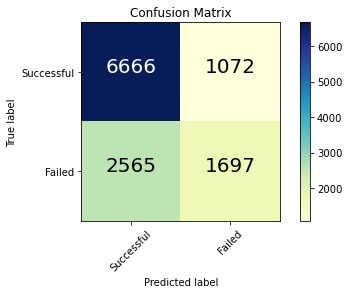

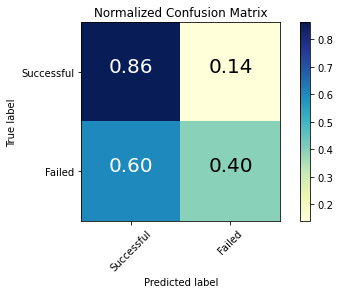

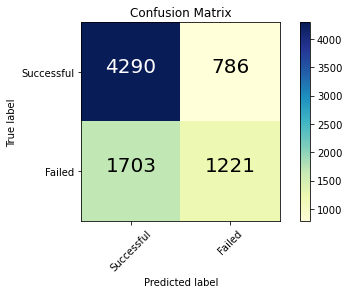

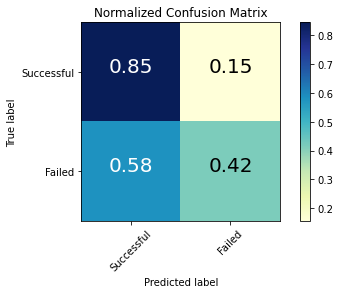

In [9]:
# parameters
optimal_C = 1
optimal_penalty = "l2"
folds = 10

# [LOGISTIC REGRESSION]
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# cross validation with K folds
logistic = LogisticRegression(C=optimal_C, penalty=optimal_penalty, solver='liblinear', random_state=1)
scores = cross_val_score(logistic, x_train, y_train, cv=folds)
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2)) 

print("-"*35)
print("TRAINING SET")
predicted_train = cross_val_predict(logistic, x_train, y_train, cv=folds)
print("-"*60)
print('[ACCURACY]\t %.2f%%' %(metrics.accuracy_score(y_train, predicted_train)*100))
print('[PRECISION]\t %.2f%%' %(metrics.precision_score(y_train, predicted_train)*100))
print('[RECALL]\t %.2f%%' %(metrics.recall_score(y_train, predicted_train)*100))
print("-"*60)
print(metrics.classification_report(y_train, predicted_train))
print(confusion_matrix(y_train, predicted_train))


cnf_matrix = metrics.confusion_matrix(y_train, predicted_train)
np.set_printoptions(precision=2)
class_names = ['Successful', 'Failed']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')


print("TESTING SET")
predicted_test = cross_val_predict(logistic, x_test, y_test, cv=folds)
print("-"*60)
print('[ACCURACY]\t %.2f%%' %(metrics.accuracy_score(y_test, predicted_test)*100))
print('[PRECISION]\t %.2f%%' %(metrics.precision_score(y_test, predicted_test)*100))
print('[RECALL]\t %.2f%%' %(metrics.recall_score(y_test, predicted_test)*100))
print("-"*60)
print(metrics.classification_report(y_test, predicted_test))
print(confusion_matrix(y_test, predicted_test))

cnf_matrix = metrics.confusion_matrix(y_test, predicted_test)
np.set_printoptions(precision=2)
class_names = ['Successful', 'Failed']

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')


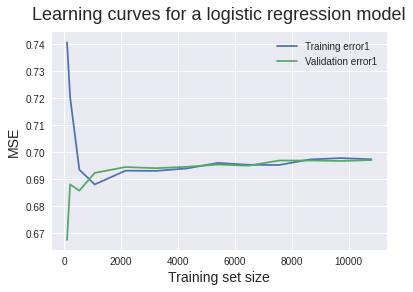

In [10]:
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression

train_sizes, train_scores, valid_scores = learning_curve(estimator = LogisticRegression(C=optimal_C, penalty=optimal_penalty), X=x_train, y=y_train, train_sizes = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], cv = folds)

train_scores_mean = train_scores.mean(axis = 1)
valid_scores_mean = valid_scores.mean(axis = 1)

import matplotlib.pyplot as plt

plt.figure()
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a logistic regression model', fontsize = 18, y = 1.03)
plt.legend()

